# NBA Data Analysis
Author: Dr. Goku Moneymaker


# Housekeeping

## Installs

## Imports / Constants

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import xgboost as xgb
from xgboost import XGBClassifier, DMatrix, XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import warnings
import json
import pytz
import requests
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.utils import resample
from IPython.display import HTML
from bs4 import BeautifulSoup
import time
import selenium as gs
import shutil
from selenium.webdriver.common.by import By
from IPython.display import Javascript
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})'''))
#from skopt import BayesSearchCV
import os

def download_current_data(date=None):
    # Define the base URL and parameters
    base_url = "https://www.bigdataball.com/wp-admin/admin-ajax.php?action=outofthebox-download"
    account_id = "dbid:AADL0JM6TbjOPoH-7_QmtAYk4iT4-vis0Tk"
    listtoken = "421f46cd8fe7a43b705e438648517e48"

    # Get current date in the required format
    current_date = datetime.now()
    yesterday = current_date - timedelta(1)
    current_date = yesterday.strftime("%m-%d-%Y") if date == None else date
    filename = f"{current_date}-nba-season-team-feed.xlsx"
    outofthebox_path = f"%2F{filename}"

    # Construct the full URL
    full_url = f"{base_url}&OutoftheBoxpath={outofthebox_path}&lastpath=%2F&account_id={account_id}&listtoken={listtoken}&dl=1"

    # Directory to save the file
    save_dir = "./"
    save_path = os.path.join(save_dir, filename)
    print(save_path)

    # don't redownload if we already have it
    if os.path.exists(save_path):
        return filename

    # Use curl to download the file
    response = requests.get(full_url, stream=True)
    print(response.status_code)
    if response.status_code == 200:
        with open(save_path, 'wb') as f:
            f.write(response.content)
    return filename

column_mappings = {
    "COLS": ['GAME-ID', 'DATE', 'TEAM', '1Q', '2Q', '3Q', '4Q', 'F', 'MIN', 'FG', 'FGA', '3P', '3PA', 'FT', 'FTA', 'OR', 'DR', 'TOT', 'A', 'PF', 'ST', 'TO', 'BL', 'PTS', 'POSS', 'PACE', 'OEFF', 'DEFF', 'TEAM_REST_DAYS', 'MAIN REF', 'CREW', 'OPENING ODDS', 'OPENING SPREAD', 'OPENING TOTAL', 'CLOSING_ODDS', 'CLOSING_SPREAD', 'CLOSING_TOTAL', 'MONEYLINE', 'HALFTIME'],
    "cleaned_cols": ['Dataset', 'GAME-ID', 'DATE', 'TEAM', 'VENUE', '1Q', '2Q', '3Q', '4Q', 'OT1', 'OT2', 'OT3', 'OT4', 'OT5', 'F', 'MIN', 'FG', 'FGA', '3P', '3PA', 'FT', 'FTA', 'OR', 'DR', 'TOT', 'A', 'PF', 'ST', 'TO', 'TO_TO', 'BL', 'PTS', 'POSS', 'PACE', 'OEFF', 'DEFF', 'TEAM_REST_DAYS', 'STARTER_1', 'STARTER_2', 'STARTER_3', 'STARTER_4', 'STARTER_5', 'MAIN REF', 'CREW', 'OPENING ODDS', 'OPENING SPREAD', 'OPENING TOTAL', 'LINE_MOVEMENT_1', 'LINE_MOVEMENT_2', 'LINE_MOVEMENT_3', 'CLOSING_ODDS', 'CLOSING_SPREAD', 'CLOSING_TOTAL', 'MONEYLINE', 'HALFTIME', 'BOX_SCORE_URL', 'ODDS_URL', 'BIGDATABALL_DATASET', 'FULL_GAME_ODDS_URL', 'REFEREE_UMPIRE'],
    "t_cleaned_cols": ['BIGDATABALL_DATASET', 'GAME-ID', 'DATE', 'TEAM', 'VENUE', '1Q', '2Q', '3Q', '4Q', 'OT1', 'OT2', 'OT3', 'OT4', 'OT5', 'F', 'MIN', 'FG', 'FGA', '3P', '3PA', 'FT', 'FTA', 'OR', 'DR', 'TOT', 'A', 'PF', 'ST', 'TO', 'TO_TO', 'BL', 'PTS', 'POSS', 'PACE', 'OEFF', 'DEFF', 'TEAM_REST_DAYS', 'STARTER_1', 'STARTER_2', 'STARTER_3', 'STARTER_4', 'STARTER_5', 'MAIN REF', 'CREW', 'OPENING_ODDS', 'OPENING_SPREAD', 'OPENING_TOTAL', 'LINE_MOVEMENT_1', 'LINE_MOVEMENT_2', 'LINE_MOVEMENT_3', 'CLOSING_ODDS', 'CLOSING_SPREAD', 'CLOSING_TOTAL', 'MONEYLINE', 'HALFTIME', 'BOX_SCORE_URL', 'FULL_GAME_ODDS_URL'],
    "TRAIN_COLS": ['Opp_Elo', 'Opp_Momentum', 'SPREAD_LINE_MOVEMENT_1', 'SPREAD_LINE_MOVEMENT_2', 'SPREAD_LINE_MOVEMENT_3', 'TOTAL_LINE_MOVEMENT_1', 'TOTAL_LINE_MOVEMENT_2', 'TOTAL_LINE_MOVEMENT_3', 'CREW', 'Opp_Avg_3_game_DEFF', 'Opp_Avg_5_game_DEFF', 'Opp_Season_Avg_DEFF', 'Opp_Avg_3_game_OEFF', 'Opp_Avg_5_game_OEFF', 'Opp_Season_Avg_OEFF', 'Opp_Avg_3_game_PACE', 'Opp_Avg_5_game_PACE', 'Opp_Season_Avg_PACE', 'Opp_Avg_3_game_POSS', 'Opp_Avg_5_game_POSS', 'Opp_Season_Avg_POSS', 'Avg_3_game_DEFF', 'Avg_5_game_DEFF', 'Season_Avg_DEFF', 'Avg_3_game_OEFF', 'Avg_5_game_OEFF', 'Season_Avg_OEFF', 'Avg_3_game_PACE', 'Avg_5_game_PACE', 'Season_Avg_PACE', 'Avg_3_game_POSS', 'Avg_5_game_POSS', 'Season_Avg_POSS', 'CLOSING_SPREAD', 'CLOSING_TOTAL', 'MONEYLINE', 'Avg_3_game_PTS', 'Avg_5_game_PTS', 'Season_Avg_PTS', 'Streak', 'Last_ML_1', 'Last_ML_2', 'Last_ML_3', 'VENUE', 'TEAM', 'Opponent', 'Win_Loss_Diff', 'HOME TEAM WIN%', 'HOME TEAM POINTS DIFFERENTIAL', 'TOTAL POINTS PER GAME', 'CALLED FOULS PER GAME', 'FOUL% AGAINST ROAD TEAMS', 'FOUL% AGAINST HOME TEAMS', 'FOUL DIFFERENTIAL (Against Road Team) - (Against Home Team)', 'Elo_Rating', 'Momentum', 'MAIN REF', 'TEAM_REST_DAYS'],
    "today_mappings": ['Last_ML_1'],
    "TARGET": 'Result',
    "SEASON_MAP": {'NBA 2021-2022 Regular Season': 2022, 'NBA 2020-2021 Regular Season': 2021, 'NBA 2019-2020 Regular Season': 2020, 'NBA 2022-2023 Regular Season': 2023, 'NBA 2020 Playoffs': 2020, 'NBA 2021 Play-in': 2021, 'NBA 2021 Playoffs': 2021, 'NBA 2023 Play-In': 2023, 'NBA 2022 Play-In': 2022, 'NBA 2023 Playoffs': 2023, 'NBA 2022 Playoffs': 2022, 'NBA 2023-2024 Regular Season': 2024, 'NBA 2023 In-Season Tournament': 2024},
    "t_train_cols": ['Opp_Elo', 'Opp_Momentum', 'SPREAD_LINE_MOVEMENT_1', 'SPREAD_LINE_MOVEMENT_2', 'SPREAD_LINE_MOVEMENT_3', 'TOTAL_LINE_MOVEMENT_1', 'TOTAL_LINE_MOVEMENT_2', 'TOTAL_LINE_MOVEMENT_3', 'CREW', 'Opp_Avg_3_game_DEFF', 'Opp_Avg_5_game_DEFF', 'Opp_Season_Avg_DEFF', 'Opp_Avg_3_game_OEFF', 'Opp_Avg_5_game_OEFF', 'Opp_Season_Avg_OEFF', 'Opp_Avg_3_game_PACE', 'Opp_Avg_5_game_PACE', 'Opp_Season_Avg_PACE', 'Opp_Avg_3_game_POSS', 'Opp_Avg_5_game_POSS', 'Opp_Season_Avg_POSS','Avg_3_game_DEFF', 'Avg_5_game_DEFF', 'Season_Avg_DEFF', 'Avg_3_game_OEFF', 'Avg_5_game_OEFF', 'Season_Avg_OEFF', 'Avg_3_game_PACE', 'Avg_5_game_PACE', 'Season_Avg_PACE', 'Avg_3_game_POSS', 'Avg_5_game_POSS', 'Season_Avg_POSS', 'CLOSING_SPREAD', 'CLOSING_TOTAL', 'MONEYLINE', 'Avg_3_game_PTS', 'Avg_5_game_PTS', 'Season_Avg_PTS', 'Streak', 'Last_ML_1', 'Last_ML_2', 'Last_ML_3', 'VENUE', 'TEAM', 'Opponent', 'Win_Loss_Diff', 'HOME TEAM WIN%', 'HOME TEAM POINTS DIFFERENTIAL', 'TOTAL POINTS PER GAME', 'CALLED FOULS PER GAME', 'FOUL% AGAINST ROAD TEAMS', 'FOUL% AGAINST HOME TEAMS', 'FOUL DIFFERENTIAL (Against Road Team) - (Against Home Team)', 'Elo_Rating', 'Momentum', 'MAIN REF', 'TEAM_REST_DAYS'],
    "train_cols_final": ['Opp_Elo', 'Opp_Momentum', 'SPREAD_LINE_MOVEMENT_1', 'SPREAD_LINE_MOVEMENT_2', 'SPREAD_LINE_MOVEMENT_3', 'TOTAL_LINE_MOVEMENT_1', 'TOTAL_LINE_MOVEMENT_2', 'TOTAL_LINE_MOVEMENT_3', 'CREW', 'Opp_Avg_3_game_DEFF', 'Opp_Avg_5_game_DEFF', 'Opp_Season_Avg_DEFF', 'Opp_Avg_3_game_OEFF', 'Opp_Avg_5_game_OEFF', 'Opp_Season_Avg_OEFF', 'Opp_Avg_3_game_PACE', 'Opp_Avg_5_game_PACE', 'Opp_Season_Avg_PACE', 'Opp_Avg_3_game_POSS', 'Opp_Avg_5_game_POSS', 'Opp_Season_Avg_POSS','Avg_3_game_DEFF', 'Avg_5_game_DEFF', 'Season_Avg_DEFF', 'Avg_3_game_OEFF', 'Avg_5_game_OEFF', 'Season_Avg_OEFF', 'Avg_3_game_PACE', 'Avg_5_game_PACE', 'Season_Avg_PACE', 'Avg_3_game_POSS', 'Avg_5_game_POSS', 'Season_Avg_POSS', 'CLOSING_SPREAD', 'CLOSING_TOTAL', 'MONEYLINE', 'Avg_3_game_PTS', 'Avg_5_game_PTS', 'Season_Avg_PTS', 'Streak', 'Last_ML_1', 'Last_ML_2', 'Last_ML_3', 'VENUE', 'TEAM', 'Opponent', 'Win_Loss_Diff', 'HOME TEAM WIN%', 'HOME TEAM POINTS DIFFERENTIAL', 'TOTAL POINTS PER GAME', 'CALLED FOULS PER GAME', 'FOUL% AGAINST ROAD TEAMS', 'FOUL% AGAINST HOME TEAMS', 'FOUL DIFFERENTIAL (Against Road Team) - (Against Home Team)', 'Elo_Rating', 'Momentum', 'MAIN REF', 'TEAM_REST_DAYS']
}

team_map = {
    'Hawks': 'Atlanta',
    'Nets': 'Brooklyn',
    'Celtics': 'Boston',
    'Hornets': 'Charlotte',
    'Bulls': 'Chicago',
    'Cavaliers': 'Cleveland',
    'Mavericks': 'Dallas',
    'Nuggets': 'Denver',
    'Pistons': 'Detroit',
    'Warriors': 'Golden State',
    'Rockets': 'Houston',
    'Pacers': 'Indiana',
    'Clippers': 'LA Clippers',
    'Lakers': 'LA Lakers',
    'Grizzlies': 'Memphis',
    'Heat': 'Miami',
    'Bucks': 'Milwaukee',
    'Timberwolves': 'Minnesota',
    'Pelicans': 'New Orleans',
    'Knicks': 'New York',
    'Thunder': 'Oklahoma City',
    'Magic': 'Orlando',
    '76ers': 'Philadelphia',
    'Suns': 'Phoenix',
    'Trail Blazers': 'Portland',
    'Kings': 'Sacramento',
    'Spurs': 'San Antonio',
    'Raptors': 'Toronto',
    'Jazz': 'Utah',
    'Wizards': 'Washington'
}
# To save this as a JSON object, you can use the following code


with open('column_mappings.json', 'w') as file:
    json.dump(column_mappings, file)

with open('column_mappings.json', 'r') as file:
    column_mappings = json.load(file)

# Now, you can access your column lists like this
COLS = column_mappings['COLS']
cleaned_cols = column_mappings['cleaned_cols']
t_cleaned_cols = column_mappings['t_cleaned_cols']
TRAIN_COLS = column_mappings['TRAIN_COLS']
today_mappings = column_mappings['today_mappings']
TARGET = column_mappings['TARGET']
SEASON_MAP = column_mappings['SEASON_MAP']
t_train_cols = column_mappings['t_train_cols']
train_cols_final = column_mappings['train_cols_final']

warnings.filterwarnings('ignore')

<IPython.core.display.Javascript object>

## File Downloads

In [3]:
TODAY_FILE = download_current_data()

./01-13-2024-nba-season-team-feed.xlsx
200


## Helper Functions

In [7]:
def american_odds_to_probability(odds):
    if odds > 0:
        probability = 100 / (odds + 100)
    else:
        probability = -odds / (-odds + 100)
    return probability

def calculate_profit(odds, size):
    if odds > 0:
        profit = (odds / 100) * size
    else:
        profit = (100 / -(odds + 0.0000001)) * size
    return profit

def kelly_criterion(bankroll, probability, odds, temper=1):
    """
    Calculate the optimal bet size using the Kelly Criterion.

    :param bankroll: Total amount of money you have to bet with.
    :param probability: The probability of the bet winning (from 0 to 1).
    :param odds: The odds being offered on the bet (in decimal format).
    :return: The recommended bet size according to the Kelly Criterion.
    """
    # Convert American odds to decimal if necessary
    if odds > 0:
        odds = (odds / 100) + 1
    elif odds < 0:
        odds = (100 / -odds) + 1

    # Calculate the Kelly bet fraction
    b = odds - 1  # Decimal odds minus 1
    q = 1 - probability  # Probability of losing
    kelly_fraction = (b * probability - q) / b

    # Calculate the recommended bet
    recommended_bet = (temper * kelly_fraction) * bankroll

    return recommended_bet

def combine_parlay_odds(odds_list):
    total_multiplier = 1
    for odds in odds_list:
        if odds > 0:  # Positive odds
            total_multiplier *= (odds / 100) + 1
        else:  # Negative odds
            total_multiplier *= 1 - (100 / (odds + 0.0000001))

    # Calculate parlay odds
    if total_multiplier >= 2:
        parlay_odds = (total_multiplier - 1) * 100
    else:
        parlay_odds = -100 / ((total_multiplier - 1) + 0.00000001)
    return parlay_odds

def get_top_bottom_features_with_scores(pred_contributions, feature_names):
    # Pair feature names with their contributions
    feature_contributions = zip(feature_names, pred_contributions)

    # Sort by the absolute value of contributions but keep the original sign
    sorted_features = sorted(feature_contributions, key=lambda x: abs(x[1]), reverse=True)

    # Get top 5 and bottom 5 features based on absolute value
    top_5_features = sorted_features[:5]
    bottom_5_features = sorted_features[-5:]

    return top_5_features, bottom_5_features

    return round(parlay_odds)
def print_wrapper(func):
    ansi_reset = '\033[0m'
    ansi_black = '\033[90m'
    ansi_red = '\033[91m'
    ansi_green = '\033[92m'
    ansi_yellow = '\033[93m'
    ansi_blue = '\033[94m'
    ansi_pink = '\033[95m'
    ansi_teal = '\033[96m'
    ansi_gray = '\033[97m'
    ansi_warning = '\033[31;1;4m'
    ansi_error = '\033[31;100m'
    def wrapped_func(*args,**kwargs):
        new_args = args + tuple()
        new_kwargs = kwargs.copy()
        for kwarg, kwvalue in kwargs.items(): # Loop through the keyword arguments
            if kwarg == "color":
                if kwvalue == "black":
                    color = ansi_black
                elif kwvalue == "red":
                    color = ansi_red
                elif kwvalue == "green":
                    color = ansi_green
                elif kwvalue == "yellow":
                    color = ansi_yellow
                elif kwvalue == "blue":
                    color = ansi_blue
                elif kwvalue == "pink":
                    color = ansi_pink
                elif kwvalue == "teal":
                    color = ansi_teal
                elif kwvalue == "gray":
                    color = ansi_gray
                elif kwvalue == "warning":
                    color = ansi_warning
                elif kwvalue == "error":
                    color = ansi_error
                new_kwargs = kwargs.copy() # Make a copy of the keyword arguments dict
                del new_kwargs["color"] # Remove color from the keyword arguments dict
        try: # Is the variable color defined?
            color
        except NameError:
            pass
            # no color was specified
        else:
            new_args = ()
            for arg in args:
                new_args += (f"{color}{arg}{ansi_reset}",) # Apply the ANSI escape codes to each non-keyword argument
        return func(*new_args,**new_kwargs)
    return wrapped_func

print = print_wrapper(print) # Apply the wrapper to the print() function

def probability_to_american_odds(probability):
    if probability < 0 or probability > 1:
        raise ValueError("Probability must be between 0 and 1")

    if probability == 0.5:
        return 100  # Even odds

    if probability > 0.5:
        return int(-100 * (probability / (1 - probability)))
    else:
        return int(100 * ((1 - probability) / probability))

def odds_to_str(odds):
  if odds <= 0:
    return odds
  else:
    return f'+{odds}'


def update_elo_momentum(row):
    df = infer_df
    #do_train = train

    K = 20  # K-factor in Elo rating
    m = 1.2 # m factor in momentup
    momentum_decay = 0.1  # Decay factor for momentum

    team = row['TEAM']
    opponent = df[(df['GAME-ID'] == row['GAME-ID']) & (df['TEAM'] != team)]['TEAM'].values[0]
    team_elo, opponent_elo = elo_ratings[team], elo_ratings[opponent]

    #if do_train:
    tm, om =  momentum_scores[team], momentum_scores[opponent]

    # Calculate expected outcomes
    expected_team = 1 / (1 + 10 ** ((opponent_elo - team_elo) / 400))

    # Actual outcome
    actual_team = row['Result']

    # Update Elo ratings
    elo_ratings[team] += K * (actual_team - expected_team)
    #elo_ratings[opponent] += K * ((1 - actual_team) - (1 - expected_team))

    # Calculate Elo difference
    elo_diff = abs(opponent_elo - team_elo)

    # Update momentum
    momentum_scores[team] = momentum_decay * (momentum_scores[team] + elo_diff) if actual_team == 1 else momentum_decay * (momentum_scores[team] - (elo_diff/m))

    return elo_ratings[team], momentum_scores[team], elo_ratings[opponent], momentum_scores[opponent]

def parse_referee_data(html_content):
    soup = BeautifulSoup(html_content, 'html.parser')
    table = soup.find('table', class_='table')
    rows = table.find_all('tr')[1:]  # Skipping the header row

    ref_data = {}
    for row in rows:
        columns = row.find_all('td')
        if len(columns) < 4:
            continue  # Skip rows that don't have enough columns

        game = columns[0].get_text(strip=True)
        crew_chief = columns[1].get_text(strip=True)
        referee = columns[2].get_text(strip=True)
        umpire = columns[3].get_text(strip=True)

        # Split the game into two teams
        teams = game.split(' @ ')
        if len(teams) != 2:
            continue  # Skip if format is not as expected
        city1 = teams[0] #_city_map.get(teams[0].split()[-1] + " " + teams[0].split()[-2], "Unknown")
        city2 = teams[1] #_city_map.get(teams[1].split()[-1] + " " + teams[1].split()[-2], "Unknown")

        ref_data[city1] = [crew_chief, referee, umpire]
        ref_data[city2] = [crew_chief, referee, umpire]

    return ref_data

def remove_ref_keys(data_dict):
    return {k: v for k, v in data_dict.items() if v[0] != 'REF'}

# Step 1: Result of the Game
def assign_results(group):
    group['MAIN REF'] = [group['MAIN REF'].iloc[0]]*2
    group['CREW'] = [group['CREW'].iloc[0]]*2

    t1_spread_f = group.iloc[0]['F'] + group.iloc[0]['CLOSING_SPREAD']
    t2_spread_f = group.iloc[1]['F'] + group.iloc[1]['CLOSING_SPREAD']

    min_spread_index = np.argmin([group.iloc[0]['CLOSING_SPREAD'], group.iloc[1]['CLOSING_SPREAD']])
    dog_spread_index = np.argmax([group.iloc[0]['CLOSING_SPREAD'], group.iloc[1]['CLOSING_SPREAD']])

    res = [t1_spread_f > group.iloc[1]['F'], t2_spread_f > group.iloc[0]['F']]

    group['Result'] = res

    group['LINE_MOVEMENT_1'] = group['LINE_MOVEMENT_1'].str.split(' ').str.get(0).str.split('u').str.get(0).str.split('o').str.get(0)
    group['LINE_MOVEMENT_1'] = pd.to_numeric(group['LINE_MOVEMENT_1'], errors='coerce')
    group['SPREAD_LINE_MOVEMENT_1'] = group['LINE_MOVEMENT_1'][group['LINE_MOVEMENT_1'] < 100]
    group['TOTAL_LINE_MOVEMENT_1'] = group['LINE_MOVEMENT_1'][group['LINE_MOVEMENT_1'] >= 100]


    group['LINE_MOVEMENT_2'] = group['LINE_MOVEMENT_2'].str.split(' ').str.get(0).str.split('u').str.get(0).str.split('o').str.get(0)
    group['LINE_MOVEMENT_2'] = pd.to_numeric(group['LINE_MOVEMENT_2'], errors='coerce')
    group['SPREAD_LINE_MOVEMENT_2'] = group['LINE_MOVEMENT_2'][group['LINE_MOVEMENT_2'] < 100]
    group['TOTAL_LINE_MOVEMENT_2'] = group['LINE_MOVEMENT_2'][group['LINE_MOVEMENT_2'] >= 100]

    group['LINE_MOVEMENT_3'] = group['LINE_MOVEMENT_3'].str.split(' ').str.get(0).str.split('u').str.get(0).str.split('o').str.get(0)
    group['LINE_MOVEMENT_3'] = pd.to_numeric(group['LINE_MOVEMENT_3'], errors='coerce')
    group['SPREAD_LINE_MOVEMENT_3'] = group['LINE_MOVEMENT_3'][group['LINE_MOVEMENT_3'] < 100]
    group['TOTAL_LINE_MOVEMENT_3'] = group['LINE_MOVEMENT_3'][group['LINE_MOVEMENT_3'] >= 100]


    group['Opp_Avg_3_game_PTS'] = [group.iloc[1]['Avg_3_game_PTS'], group.iloc[0]['Avg_3_game_PTS']]
    group['Opp_Avg_5_game_PTS'] = [group.iloc[1]['Avg_5_game_PTS'], group.iloc[0]['Avg_5_game_PTS']]
    group['Opp_Season_Avg_PTS'] = [group.iloc[1]['Season_Avg_PTS'], group.iloc[0]['Season_Avg_PTS']]

    group['Opp_Avg_3_game_POSS'] = [group.iloc[1]['Avg_3_game_POSS'], group.iloc[0]['Avg_3_game_POSS']]
    group['Opp_Avg_5_game_POSS'] = [group.iloc[1]['Avg_5_game_POSS'], group.iloc[0]['Avg_5_game_POSS']]
    group['Opp_Season_Avg_POSS'] = [group.iloc[1]['Season_Avg_POSS'], group.iloc[0]['Season_Avg_POSS']]

    group['Opp_Avg_3_game_PACE'] = [group.iloc[1]['Avg_3_game_PACE'], group.iloc[0]['Avg_3_game_PACE']]
    group['Opp_Avg_5_game_PACE'] = [group.iloc[1]['Avg_5_game_PACE'], group.iloc[0]['Avg_5_game_PACE']]
    group['Opp_Season_Avg_PACE'] = [group.iloc[1]['Season_Avg_PACE'], group.iloc[0]['Season_Avg_PACE']]

    group['Opp_Avg_3_game_DEFF'] = [group.iloc[1]['Avg_3_game_DEFF'], group.iloc[0]['Avg_3_game_DEFF']]
    group['Opp_Avg_5_game_DEFF'] = [group.iloc[1]['Avg_5_game_DEFF'], group.iloc[0]['Avg_5_game_DEFF']]
    group['Opp_Season_Avg_DEFF'] = [group.iloc[1]['Season_Avg_DEFF'], group.iloc[0]['Season_Avg_DEFF']]

    group['Opp_Avg_3_game_OEFF'] = [group.iloc[1]['Avg_3_game_OEFF'], group.iloc[0]['Avg_3_game_OEFF']]
    group['Opp_Avg_5_game_OEFF'] = [group.iloc[1]['Avg_5_game_OEFF'], group.iloc[0]['Avg_5_game_OEFF']]
    group['Opp_Season_Avg_OEFF'] = [group.iloc[1]['Season_Avg_OEFF'], group.iloc[0]['Season_Avg_OEFF']]

    return group


def assign_opp_elo(group):
    group['Opp_Elo'] = [group.iloc[1]['Elo_Rating'], group.iloc[0]['Elo_Rating']]
    group['Opp_Momentum'] = [group.iloc[1]['Momentum'], group.iloc[0]['Momentum']]
    return group

# Step 3: Win/Loss Streak
def calculate_streak(group):
    streak = 0
    streaks = []
    for result in group['Prev_Result']:
        if result == 1:
            streak = streak + 1 if streak > 0 else 1
        else:
            streak = streak - 1 if streak < 0 else -1
        streaks.append(streak)
    group['Streak'] = streaks
    return group

# Scrape Today Data

## Scrape Odds

In [5]:
# Initialize WebDriver
driver = webdriver.Chrome()
driver.get('https://www.scoresandodds.com/nba?date=2024-01-14')

# Wait for page to load
time.sleep(3)

# Find the table by its class
tables = driver.find_elements(By.CLASS_NAME, 'event-card-table')

current_odds = {}
games = []
team = None
for table in tables:
    # Find all rows in the table
    rows = table.find_elements(By.CLASS_NAME, 'event-card-row')
    all_moves = [float(''.join(c for c in m.text if (c.isdigit() or c =='.' or c == '-'))) for m in table.find_elements(By.CSS_SELECTOR, '[data-tab*="#line-movements"] .data-value')]
    s_moves = []
    t_moves = []
    for m in all_moves:
      if abs(m) < 100:
        s_moves.append(m)
      else:
        t_moves.append(m)

    i = 0
    teams = []

    home_row = table.find_element(By.CSS_SELECTOR, '[data-side="home"]')
    away_row = table.find_element(By.CSS_SELECTOR, '[data-side="away"]')

    home_team = home_row.find_element(By.CSS_SELECTOR, '.team-name span').text
    away_team = away_row.find_element(By.CSS_SELECTOR, '.team-name span').text

    h_ml = int(home_row.find_element(By.CSS_SELECTOR, '[data-field="current-moneyline"] .data-value').text)
    h_spread = float(''.join(c for c in home_row.find_element(By.CSS_SELECTOR, '[data-field="current-spread"] .data-value').text if (c.isdigit() or c == '.' or c == '-')))
    h_total = float(''.join(c for c in home_row.find_element(By.CSS_SELECTOR, '[data-field="current-total"] .data-value').text if (c.isdigit() or c == '.' or c == '-')))

    home = ['REF', h_ml, 'H', team_map[away_team], h_spread, h_total, s_moves[-3:], t_moves[-3:], 'CREW', 'UMPIRE']

    a_ml = int(away_row.find_element(By.CSS_SELECTOR, '[data-field="current-moneyline"] .data-value').text)
    a_spread = float(''.join(c for c in away_row.find_element(By.CSS_SELECTOR, '[data-field="current-spread"] .data-value').text if (c.isdigit() or c == '.' or c == '-')))
    a_total = float(''.join(c for c in away_row.find_element(By.CSS_SELECTOR, '[data-field="current-total"] .data-value').text if (c.isdigit() or c == '.' or c == '-')))

    away = ['REF', a_ml, 'R', team_map[home_team], a_spread, a_total, s_moves[-3:], t_moves[-3:], 'CREW', 'UMPIRE']

    current_odds[team_map[home_team]] = home
    current_odds[team_map[away_team]] = away

driver.quit()
print('DONE')



AttributeError: module 'selenium' has no attribute 'Chrome'

## Scrape Refs

In [7]:
driver = gs.Chrome()
driver.get('https://official.nba.com/referee-assignments/')

# Wait for JavaScript to load
time.sleep(3)

# Get the HTML content of the page
html_content = driver.page_source

# Close the browser
driver.quit()

referee_data = parse_referee_data(html_content)

for city, refs in referee_data.items():
    try:
        if city == 'L.A. Lakers':
          city = 'LA Lakers'
        current_odds[city][0] = ' '.join(refs[0].split(' ')[:-1])
        current_odds[city][-2] = ' '.join(refs[1].split(' ')[:-1])
        current_odds[city][-1] = ' '.join(refs[2].split(' ')[:-1])
    except:
      pass

processed_data = remove_ref_keys(current_odds)
TODAY_MAP = processed_data
display(pd.DataFrame(TODAY_MAP))

<IPython.core.display.Javascript object>

,Boston,Houston,Atlanta,Washington,Memphis,New York,Oklahoma City,Orlando,Milwaukee,Golden State,San Antonio,Chicago,Dallas,New Orleans,Utah,LA Lakers
0,Ed Malloy,Ed Malloy,Mark Lindsay,Mark Lindsay,Kevin Scott,Kevin Scott,Tony Brothers,Tony Brothers,Zach Zarba,Zach Zarba,Kevin Cutler,Kevin Cutler,Curtis Blair,Curtis Blair,Pat Fraher,Pat Fraher
1,-1150,730,-270,220,440,-590,-600,450,-1000,660,200,-245,-176,148,-138,118
2,H,R,H,R,H,R,H,R,H,R,H,R,H,R,H,R
3,Houston,Boston,Washington,Atlanta,New York,Memphis,Orlando,Oklahoma City,Golden State,Milwaukee,Chicago,San Antonio,New Orleans,Dallas,LA Lakers,Utah
4,-15.0,15.0,-7.0,7.0,11.0,-11.0,-11.5,11.5,-13.5,13.5,6.5,-6.5,-4.0,4.0,-2.5,2.5
5,226.5,226.5,248.5,248.5,220.0,220.0,232.0,232.0,241.0,241.0,229.0,229.0,230.0,230.0,237.5,237.5
6,"[-15.0, -15.0, -15.0]","[-15.0, -15.0, -15.0]","[-7.0, -7.0, -7.0]","[-7.0, -7.0, -7.0]","[-11.0, -11.0, -11.0]","[-11.0, -11.0, -11.0]","[-11.5, -11.5, -11.5]","[-11.5, -11.5, -11.5]","[-13.5, -13.5, -14.0]","[-13.5, -13.5, -14.0]","[-6.5, -6.5, -6.0]","[-6.5, -6.5, -6.0]","[-4.0, -3.5, -3.5]","[-4.0, -3.5, -3.5]","[-2.5, -2.5, -2.5]","[-2.5, -2.5, -2.5]"
7,"[226.5, 227.0, 227.0]","[226.5, 227.0, 227.0]","[248.5, 248.5, 249.0]","[248.5, 248.5, 249.0]","[220.0, 220.0, 220.0]","[220.0, 220.0, 220.0]","[232.0, 231.5, 231.5]","[232.0, 231.5, 231.5]","[241.0, 241.0, 241.0]","[241.0, 241.0, 241.0]","[229.0, 229.0, 229.0]","[229.0, 229.0, 229.0]","[230.0, 229.5, 233.5]","[230.0, 229.5, 233.5]","[237.0, 237.0, 235.5]","[237.0, 237.0, 235.5]"
8,CJ Washington,CJ Washington,Michael Smith,Michael Smith,Ray Acosta,Ray Acosta,Gediminas Petraitis,Gediminas Petraitis,James Williams,James Williams,Sean Corbin,Sean Corbin,Jason Goldenberg,Jason Goldenberg,Justin Van Duyne,Justin Van Duyne
9,Matt Kallio,Matt Kallio,Suyash Mehta,Suyash Mehta,John Conley,John Conley,Jenna Schroeder,Jenna Schroeder,Brett Nansel,Brett Nansel,Leon Wood,Leon Wood,Mousa Dagher,Mousa Dagher,Scott Twardoski,Scott Twardoski


# Training

## Load Raw Data

In [8]:
team_df_2019 = pd.read_excel('2018-2019_NBA_Box_Score_Team-Stats.xlsx')
team_df_2020 = pd.read_excel('2019-2020_NBA_Box_Score_Team-Stats.xlsx')
team_df_2021 = pd.read_excel('2020-2021_NBA_Box_Score_Team-Stats.xlsx')
team_df_2022 = pd.read_excel('2021-2022_NBA_Box_Score_Team-Stats.xlsx')
team_df_2023 = pd.read_excel('2022-2023_NBA_Box_Score_Team-Stats.xlsx')
tdf = pd.read_excel(TODAY_FILE)
refs_2019 = pd.read_csv('2018-2019.csv')
refs_2020 = pd.read_csv('2019-2020.csv')
refs_2021 = pd.read_csv('2020-2021.csv')
refs_2022 = pd.read_csv('2021_2022.csv')
refs_2023 = pd.read_csv('2022-2023.csv')
refs_2024 = pd.read_csv('2023-2024.csv')

refs = pd.concat([refs_2019, refs_2020, refs_2021, refs_2022, refs_2023, refs_2024])
raw_df = pd.concat([team_df_2019, team_df_2020, team_df_2021, team_df_2022, team_df_2023])
raw_df.columns = cleaned_cols
tdf.columns = t_cleaned_cols

rename_map = {
    'OPENING_ODDS': 'OPENING ODDS',
    'FULL_GAME_ODDS_URL': 'ODDS_URL'
}

tdf.rename(columns=rename_map, inplace=True)

# Step 2: Add missing columns in df2 (if any)
missing_cols = set(cleaned_cols) - set(tdf.columns)
for col in missing_cols:
    tdf[col] = pd.NA


#Step 3: Concatenate the DataFrames
raw_df = pd.concat([raw_df, tdf], ignore_index=True)

""" Add additional columns to games df """
raw_df['Season'] = raw_df['BIGDATABALL_DATASET'].map(SEASON_MAP)
raw_df['DATE'] = raw_df['DATE'].astype('datetime64[ns]')
infer_df = raw_df.copy(deep=True)


## Build Train Dataframe

In [9]:
train_df = raw_df.copy(deep=True)
# Initialize Elo ratings and momentum scores
elo_ratings = {team: 1500 for team in train_df['TEAM'].unique()}
momentum_scores = {team: 0 for team in train_df['TEAM'].unique()}

# Average Points
train_df['Avg_3_game_PTS'] = train_df.groupby(['TEAM', 'Season'])['PTS'].transform(lambda x: x.shift(1).rolling(3).mean())
train_df['Avg_5_game_PTS'] = train_df.groupby(['TEAM', 'Season'])['PTS'].transform(lambda x: x.shift(1).rolling(5).mean())
train_df['Season_Avg_PTS'] = train_df.groupby(['TEAM', 'Season'])['PTS'].transform('mean')

# Average POSS
train_df['Avg_3_game_POSS'] = train_df.groupby(['TEAM', 'Season'])['POSS'].transform(lambda x: x.shift(1).rolling(3).mean())
train_df['Avg_5_game_POSS'] = train_df.groupby(['TEAM', 'Season'])['POSS'].transform(lambda x: x.shift(1).rolling(5).mean())
train_df['Season_Avg_POSS'] = train_df.groupby(['TEAM', 'Season'])['POSS'].transform('mean')

# Average PACE
train_df['Avg_3_game_PACE'] = train_df.groupby(['TEAM', 'Season'])['PACE'].transform(lambda x: x.shift(1).rolling(3).mean())
train_df['Avg_5_game_PACE'] = train_df.groupby(['TEAM', 'Season'])['PACE'].transform(lambda x: x.shift(1).rolling(5).mean())
train_df['Season_Avg_PACE'] = train_df.groupby(['TEAM', 'Season'])['PACE'].transform('mean')

# Average OEFF
train_df['Avg_3_game_OEFF'] = train_df.groupby(['TEAM', 'Season'])['OEFF'].transform(lambda x: x.shift(1).rolling(3).mean())
train_df['Avg_5_game_OEFF'] = train_df.groupby(['TEAM', 'Season'])['OEFF'].transform(lambda x: x.shift(1).rolling(5).mean())
train_df['Season_Avg_OEFF'] = train_df.groupby(['TEAM', 'Season'])['OEFF'].transform('mean')

# Average DEFF
train_df['Avg_3_game_DEFF'] = train_df.groupby(['TEAM', 'Season'])['DEFF'].transform(lambda x: x.shift(1).rolling(3).mean())
train_df['Avg_5_game_DEFF'] = train_df.groupby(['TEAM', 'Season'])['DEFF'].transform(lambda x: x.shift(1).rolling(5).mean())
train_df['Season_Avg_DEFF'] = train_df.groupby(['TEAM', 'Season'])['DEFF'].transform('mean')

# Apply the function to each game group
train_df = train_df.groupby('GAME-ID').apply(assign_results)

# Reset index
train_df.reset_index(drop=True, inplace=True)

# Shift the Result column for streak calculation
train_df['Prev_Result'] = train_df.groupby(['TEAM', 'Season'])['Result'].shift()

# Calculate Streaks
train_df = train_df.groupby(['TEAM', 'Season']).apply(calculate_streak)

# Last 3 Games Moneylines
train_df['Last_ML_1'] = train_df.groupby(['TEAM', 'Season'])['MONEYLINE'].shift(1)
train_df['Last_ML_2'] = train_df.groupby(['TEAM', 'Season'])['MONEYLINE'].shift(2)
train_df['Last_ML_3'] = train_df.groupby(['TEAM', 'Season'])['MONEYLINE'].shift(3)

# Current Number of Wins - Losses
train_df['Wins'] = train_df.groupby(['TEAM', 'Season'])['Result'].cumsum()
train_df['Losses'] = train_df.groupby(['TEAM', 'Season'])['Result'].transform('count') - train_df['Wins']
train_df['Win_Loss_Diff'] = train_df['Wins'] - train_df['Losses']

# Current Opponent
train_df['Opponent'] = train_df.groupby('GAME-ID')['TEAM'].shift(-1).fillna(train_df.groupby('GAME-ID')['TEAM'].shift())

# Merge Ref Data
train_df = train_df.merge(refs.groupby('REFEREE').mean(), how='left', left_on='MAIN REF', right_on='REFEREE')

# sort by date
train_df = train_df.sort_values('DATE')

# Apply the Elo / Momentum function
train_df[['Elo_Rating', 'Momentum', 'Opp_Elo', 'Opp_Momentum']] = train_df.apply(update_elo_momentum, axis=1, result_type='expand')

train_df = train_df.groupby('GAME-ID').apply(assign_opp_elo)

# Clean up
train_df.drop('Prev_Result', axis=1, inplace=True)

## Create the Training Dataset

In [10]:
X = train_df.copy()

def offset_cols(group):
    cols = ['Elo_Rating', 'Momentum']
    group['prev_elo'] = group['Elo_Rating'].shift()
    group['prev_mom'] = group['Momentum'].shift()

    return group

def apply_prev_elo(group):
    cols = ['Elo_Rating', 'Momentum']
    group[cols] = group[cols].shift()

    return group

def assign_opp_elo_mom(group):
    group['Opp_Elo'] = [group.iloc[1]['Elo_Rating'], group.iloc[0]['Elo_Rating']]
    group['Opp_Momentum'] = [group.iloc[1]['Momentum'], group.iloc[0]['Momentum']]
    return group



X = X.groupby(['TEAM', 'Season']).apply(offset_cols)
X = X.groupby(['TEAM', 'Season']).apply(apply_prev_elo)
X = X.groupby(['GAME-ID']).apply(assign_opp_elo_mom)

y = X[TARGET]
X = X[TRAIN_COLS]
X[['MONEYLINE', 'Last_ML_1', 'Last_ML_2', 'Last_ML_3']] = X[['MONEYLINE', 'Last_ML_1', 'Last_ML_2', 'Last_ML_3',]].replace('even', '-100', regex=True)
X[['MONEYLINE', 'Last_ML_1', 'Last_ML_2', 'Last_ML_3',]] = X[['MONEYLINE', 'Last_ML_1', 'Last_ML_2', 'Last_ML_3',]].fillna(0).astype(int)
X['MAIN REF'] = X['MAIN REF'].astype('category')
X['CREW'] = X['CREW'].astype('category')
X['TEAM_REST_DAYS'] = X['TEAM_REST_DAYS'].astype('category')
X['TEAM'] = X['TEAM'].astype('category')
X['Opponent'] = X['Opponent'].astype('category')
X['VENUE'] = (X['VENUE'] == 'H')*1


# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=41)

## Train the Ensemble

In [11]:
n_bootstrap_samples = 8  # Number of bootstrap samples
bootstrap_models = []
weights_dicts = []

# Generate bootstrap samples and train a model on each
for _ in range(n_bootstrap_samples):

    X_train_sample, y_train_sample = resample(X_train, y_train, n_samples=int(len(X_train)), replace=True)
    weights_dicts.append(X_train_sample['TEAM'].value_counts())
    model = xgb.XGBClassifier(tree_method="hist", sampling_method='gradient_based', enable_categorical=True, device="cuda", verbosity=1, kwargs={
    'max_depth': [7],
    'learning_rate': [0.022],
    'n_estimators': [300],
    'gamma': [7],
    'subsample': [1],
    'colsample_bytree': [0.8],
    'min_child_weight': [15],
    'reg_lambda': [0.3],
    'reg_alpha': [0.3]
})
    model.fit(X_train_sample, y_train_sample)
    print(model.score(X_test, y_test))
    bootstrap_models.append(model)


0.47965641952983723
0.5027124773960217
0.4909584086799277
0.5009041591320073
0.4936708860759494
0.48553345388788427
0.4868896925858951
0.48282097649186256


## Backtest

2023-12-01 00:00:00...
	Won 376.23 betting 413.85
		Denver to beat Phoenix at -110 - our model pinned it at -521
Results: bankroll start: 2500 end: 2876.23 for profit of: 376.23, win rate = 1.00

2023-12-02 00:00:00...
	Lost 259.21 trying to win 235.65
		Cleveland to beat Detroit at -110 - our model pinned it at -228
	Won 459.37 betting 505.31
		Minnesota to beat Charlotte at -110 - our model pinned it at -606
	Won 132.27 betting 145.5
		Oklahoma City to beat Dallas at -110 - our model pinned it at -163
	Lost 196.85 trying to win 178.95
		Miami to beat Indiana at -110 - our model pinned it at -189
	Won 233.87 betting 257.26
		Sacramento to beat Denver at -110 - our model pinned it at -226
Results: bankroll start: 2876.23 end: 3245.68 for profit of: 369.45, win rate = 0.60

2023-12-03 00:00:00...
2023-12-04 00:00:00...
Results: bankroll start: 3245.68 end: 3245.68 for profit of: 0.0, win rate = 0.00

2023-12-05 00:00:00...
	Lost 274.23 trying to win 249.3
		Phoenix to beat LA Lakers at 

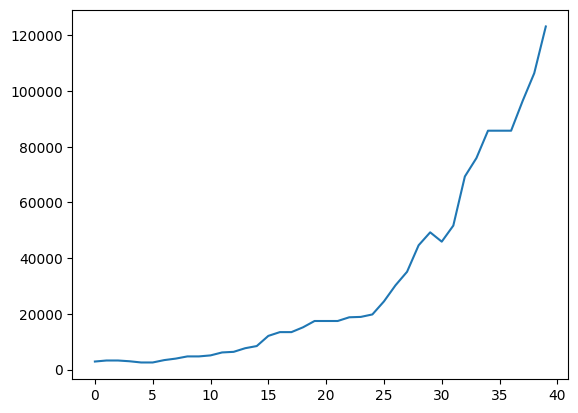

In [12]:
thresh = 0.5

def process_data_frame(df):
    df['DATE'] = pd.to_datetime(df['DATE'])
    return df.sort_values('DATE')

def update_bankroll(bankroll, profit):
    bankroll += profit
    return max(bankroll, 0)  # Prevents negative bankroll

def print_bet_results(date, wins, losses, total, bankroll, start, hit_all, all_odds, hit_all_all, all_all_odds):
    win_rate = wins / total if total > 0 else 0
    print(f'Results: bankroll start: {round(start,2)} end: {round(bankroll,2)} for profit of: {round(bankroll - start, 2)}, win rate = {win_rate:.2f}\n')

def weight_probabilities(X, raw_probs, weights_arr):
    weighted_probs = []
    for i,team in enumerate(X['TEAM']):
        w = []
        for weights in weights_arr:
            w.append((weights/X_train['TEAM'].value_counts()).pow(2)[team])
        w = np.array(w)
        w = w/w.sum()
        weighted_probs.append(w*raw_probs[:, i])
    return np.array(weighted_probs)


def backtest_model(df, model, feature_cols, label_col, odds_col, start_date, end_date, initial_bankroll, bet_size):
    df = process_data_frame(df)
    bankroll = initial_bankroll
    bet_results = []
    current_date = pd.to_datetime(start_date)

    while current_date <= pd.to_datetime(end_date):
        print(f'{current_date}...')
        day_data = df[df['DATE'] == current_date]
        start_bankroll = bankroll
        day_profit = 0
        if not day_data.empty and bankroll > 0:
            X = day_data[feature_cols]
            X[['Elo_Rating', 'Momentum']] = X[['Elo_Rating', 'Momentum']].shift()
            X[['MONEYLINE', 'Last_ML_1', 'Last_ML_2', 'Last_ML_3']] = X[['MONEYLINE', 'Last_ML_1', 'Last_ML_2', 'Last_ML_3',]].replace('even', '-100', regex=True)
            X[['MONEYLINE', 'Last_ML_1', 'Last_ML_2', 'Last_ML_3',]] = X[['MONEYLINE', 'Last_ML_1', 'Last_ML_2', 'Last_ML_3',]].fillna(0).astype(int)
            X['MAIN REF'] = X['MAIN REF'].astype('category')
            X['TEAM'] = X['TEAM'].astype('category')
            X['CREW'] = X['CREW'].astype('category')
            X['Opponent'] = X['Opponent'].astype('category')
            X['TEAM_REST_DAYS'] = X['TEAM_REST_DAYS'].astype('category')
            X['VENUE'] = (X['VENUE'] == 'H')*1
            y = day_data[label_col]
            #probabilities = model.predict_proba(X)
            preds = np.array([model.predict_proba(X)[:, 1] for model in bootstrap_models])
            #print(preds)
            preds = weight_probabilities(X, preds, weights_dicts)
            probabilities = preds.sum(axis=1)
            predictions = np.array([x > 0.5 for x in probabilities])

            ps = {team: prob for team, prob in zip(X['TEAM'].values, probabilities)}
            normed_odds = {team: ps[team]/(ps[team] + ps[opp]) for team, opp in zip(X['TEAM'], X['Opponent'])}
            do_bet = {team: normed_odds[team] > normed_odds[opp] for team, opp in zip(X['TEAM'], X['Opponent'])}

            #print(do_bet)
            wins, losses, profit, num_bets = 0, 0, 0, 0
            all_odds = []
            all_all_odds = []
            hit_all = True
            hit_all_all = True

            # SUBTRACT ONE FOR THE PARLAY RIGHT AWAY
            made_a_bet = False
            made_a_bet = 0
            # for all the options today
            for pred, actual, odds, prob, team, opp in zip(predictions, y, day_data[odds_col], probabilities, X['TEAM'].values, X['Opponent'].values):

                # only look at predicted winners
                if do_bet[team] and ps[team] - ps[opp] > 0.25:

                    # get odds as integer
                    odds = -110 #if odds == 'even' else int(odds)
                    # get optimal bet size
                    bet_size = round(kelly_criterion(start_bankroll, normed_odds[team], odds, 0.25), 2)

                    # if we can afford to bet on this
                    if (bankroll - bet_size) >= 0:

                        # how much would we win
                        to_win = round(calculate_profit(odds, bet_size), 2)

                        # if this crosses the probability threshold we want to bet on,
                        # and we don't want to bet on the other team:
                        if do_bet[team] and (bet_size > 0):
                            bankroll -= bet_size
                            num_bets += 1
                            if actual:
                                print(f'\tWon {to_win} betting {bet_size}\n\t\t{team} to beat {opp} at {odds_to_str(odds)} - our model pinned it at {int(probability_to_american_odds(normed_odds[team]))}', color='green')
                                day_profit += (to_win + bet_size)
                                wins += 1
                            else:
                                print(f'\tLost {bet_size} trying to win {to_win}\n\t\t{team} to beat {opp} at {odds_to_str(odds)} - our model pinned it at {int(probability_to_american_odds(normed_odds[team]))}', color='red')
                                losses += actual != pred
                                hit_all = False
                            all_odds.append(odds)

            bankroll += day_profit
            print_bet_results(current_date, wins, losses, num_bets, bankroll, start_bankroll, hit_all, all_odds, hit_all_all, all_all_odds)
            bet_results.append(bankroll)

        current_date += pd.Timedelta(days=1)

    return bankroll, bankroll - initial_bankroll, bet_results

# Example usage with defined constants
final_bankroll, total_profit, bet_results = backtest_model(
    df=train_df,
    model=model,
    feature_cols=TRAIN_COLS,  # feature columns
    label_col='Result',
    odds_col='MONEYLINE',
    start_date='2023-12-01',
    end_date='2024-01-13',
    initial_bankroll=2500,
    bet_size=2
)
plt.plot(bet_results)
print(f"Final Bankroll: {final_bankroll}")
print(f"Total Profit: {total_profit}")


# Inference

### temp

In [97]:
infer_df = raw_df.copy(deep=True)
infer_df = infer_df[(infer_df['DATE'] >= pd.to_datetime('2023-11-15'))]

# Average Points
infer_df['Avg_3_game_PTS'] = infer_df.groupby(['TEAM', 'Season'])['PTS'].transform(lambda x: x.rolling(3).mean())
infer_df['Avg_5_game_PTS'] = infer_df.groupby(['TEAM', 'Season'])['PTS'].transform(lambda x: x.rolling(5).mean())
infer_df['Season_Avg_PTS'] = infer_df.groupby(['TEAM', 'Season'])['PTS'].transform('mean')

# Average POSS
infer_df['Avg_3_game_POSS'] = infer_df.groupby(['TEAM', 'Season'])['POSS'].transform(lambda x: x.rolling(3).mean())
infer_df['Avg_5_game_POSS'] = infer_df.groupby(['TEAM', 'Season'])['POSS'].transform(lambda x: x.rolling(5).mean())
infer_df['Season_Avg_POSS'] = infer_df.groupby(['TEAM', 'Season'])['POSS'].transform('mean')

# Average PACE
infer_df['Avg_3_game_PACE'] = infer_df.groupby(['TEAM', 'Season'])['PACE'].transform(lambda x: x.rolling(3).mean())
infer_df['Avg_5_game_PACE'] = infer_df.groupby(['TEAM', 'Season'])['PACE'].transform(lambda x: x.rolling(5).mean())
infer_df['Season_Avg_PACE'] = infer_df.groupby(['TEAM', 'Season'])['PACE'].transform('mean')

# Average OEFF
infer_df['Avg_3_game_OEFF'] = infer_df.groupby(['TEAM', 'Season'])['OEFF'].transform(lambda x: x.rolling(3).mean())
infer_df['Avg_5_game_OEFF'] = infer_df.groupby(['TEAM', 'Season'])['OEFF'].transform(lambda x: x.rolling(5).mean())
infer_df['Season_Avg_OEFF'] = infer_df.groupby(['TEAM', 'Season'])['OEFF'].transform('mean')

# Average DEFF
infer_df['Avg_3_game_DEFF'] = infer_df.groupby(['TEAM', 'Season'])['DEFF'].transform(lambda x: x.rolling(3).mean())
infer_df['Avg_5_game_DEFF'] = infer_df.groupby(['TEAM', 'Season'])['DEFF'].transform(lambda x: x.rolling(5).mean())
infer_df['Season_Avg_DEFF'] = infer_df.groupby(['TEAM', 'Season'])['DEFF'].transform('mean')

# Apply the function to each game group
infer_df = infer_df.groupby('GAME-ID').apply(assign_results)

# Reset index
infer_df.reset_index(drop=True, inplace=True)

# Shift the Result column for streak calculation
infer_df['Prev_Result'] = infer_df['Result']

# Calculate Streaks
infer_df = infer_df.groupby(['TEAM', 'Season']).apply(calculate_streak)

# Last 3 Games Moneylines
infer_df['Last_ML_1'] = infer_df.groupby(['TEAM', 'Season'])['MONEYLINE'].shift(1)
infer_df['Last_ML_2'] = infer_df.groupby(['TEAM', 'Season'])['MONEYLINE'].shift(2)
infer_df['Last_ML_3'] = infer_df.groupby(['TEAM', 'Season'])['MONEYLINE'].shift(3)

# Current Number of Wins - Losses
infer_df['Wins'] = infer_df.groupby(['TEAM', 'Season'])['Result'].cumsum()
infer_df['Losses'] = infer_df.groupby(['TEAM', 'Season'])['Result'].transform('count') - infer_df['Wins']
infer_df['Win_Loss_Diff'] = infer_df['Wins'] - infer_df['Losses']

# Current Opponent
infer_df['Opponent'] = infer_df.groupby('GAME-ID')['TEAM'].shift(-1).fillna(infer_df.groupby('GAME-ID')['TEAM'].shift())

# Merge Ref Data
infer_df = infer_df.merge(refs.groupby('REFEREE').mean(), how='left', left_on='MAIN REF', right_on='REFEREE')

# sort by date
infer_df = infer_df.sort_values('DATE')

# Apply the Elo / Momentum function
infer_df[['Elo_Rating', 'Momentum', 'Opp_Elo', 'Opp_Momentum']] = infer_df.apply(update_elo_momentum, axis=1, result_type='expand')

def assign_opp_elo_mom(group):
    group['Opp_Elo'] = [group.iloc[1]['Elo_Rating'], group.iloc[0]['Elo_Rating']]
    group['Opp_Momentum'] = [group.iloc[1]['Momentum'], group.iloc[0]['Momentum']]
    return group

infer_df = infer_df.groupby(['GAME-ID']).apply(assign_opp_elo_mom)

# Clean up
infer_df.drop('Prev_Result', axis=1, inplace=True)

## Prepare Data

In [29]:
t_teams = list(TODAY_MAP.keys())

def get_most_recent_rows(df, teams):
    most_recent_rows = []
    for team in teams:
        team_df = df[df['TEAM'] == team]
        if not team_df.empty:
            most_recent_row = team_df.loc[team_df['DATE'].idxmax()]
            most_recent_rows.append(most_recent_row)
    return pd.DataFrame(most_recent_rows)

# Step 1: Result of the Game
def assign_opps(group):

    t1 = group.iloc[0]['Avg_3_game_DEFF', 'Avg_5_game_DEFF', 'Season_Avg_DEFF', 'Avg_3_game_OEFF', 'Avg_5_game_OEFF', 'Season_Avg_OEFF', 'Avg_3_game_PACE', 'Avg_5_game_PACE', 'Season_Avg_PACE', 'Avg_3_game_POSS', 'Avg_5_game_POSS', 'Season_Avg_POSS', 'Avg_3_game_PTS', 'Avg_5_game_PTS', 'Season_Avg_PTS', 'Elo_Rating', 'Momentum']
    t2 = group.iloc[1]['Avg_3_game_DEFF', 'Avg_5_game_DEFF', 'Season_Avg_DEFF', 'Avg_3_game_OEFF', 'Avg_5_game_OEFF', 'Season_Avg_OEFF', 'Avg_3_game_PACE', 'Avg_5_game_PACE', 'Season_Avg_PACE', 'Avg_3_game_POSS', 'Avg_5_game_POSS', 'Season_Avg_POSS', 'Avg_3_game_PTS', 'Avg_5_game_PTS', 'Season_Avg_PTS', 'Elo_Rating', 'Momentum']

    group.iloc[0]['Opp_Avg_3_game_DEFF', 'Opp_Avg_5_game_DEFF', 'Opp_Season_Avg_DEFF', 'Opp_Avg_3_game_OEFF', 'Opp_Avg_5_game_OEFF', 'Opp_Season_Avg_OEFF', 'Opp_Avg_3_game_PACE', 'Opp_Avg_5_game_PACE', 'Opp_Season_Avg_PACE', 'Opp_Avg_3_game_POSS', 'Opp_Avg_5_game_POSS', 'Opp_Season_Avg_POSS', 'Opp_Avg_3_game_PTS', 'Opp_Avg_5_game_PTS', 'Opp_Season_Avg_PTS', 'Opp_Elo', 'Opp_Momentum'] = t2
    group.iloc[1]['Opp_Avg_3_game_DEFF', 'Opp_Avg_5_game_DEFF', 'Opp_Season_Avg_DEFF', 'Opp_Avg_3_game_OEFF', 'Opp_Avg_5_game_OEFF', 'Opp_Season_Avg_OEFF', 'Opp_Avg_3_game_PACE', 'Opp_Avg_5_game_PACE', 'Opp_Season_Avg_PACE', 'Opp_Avg_3_game_POSS', 'Opp_Avg_5_game_POSS', 'Opp_Season_Avg_POSS', 'Opp_Avg_3_game_PTS', 'Opp_Avg_5_game_PTS', 'Opp_Season_Avg_PTS', 'Opp_Elo', 'Opp_Momentum'] = t1

    return group

# Get the most recent rows
tdf = get_most_recent_rows(train_df, t_teams)

ref_map = {team: details[0] for team, details in TODAY_MAP.items()}
crew_map = {team: details[-2] for team, details in TODAY_MAP.items()}
moneyline_map = {team: details[1] for team, details in TODAY_MAP.items()}
venue_map = {team: details[2] for team, details in TODAY_MAP.items()}
opp_map = {team: details[3] for team, details in TODAY_MAP.items()}
spread_map = {team: details[4] for team, details in TODAY_MAP.items()}
total_map = {team: details[5] for team, details in TODAY_MAP.items()}
s_movement_map_1 = {team: details[6][0] for team, details in TODAY_MAP.items()}
s_movement_map_2 = {team: details[6][1] for team, details in TODAY_MAP.items()}
s_movement_map_3 = {team: details[6][2] for team, details in TODAY_MAP.items()}
t_movement_map_1 = {team: details[7][0] for team, details in TODAY_MAP.items()}
t_movement_map_2 = {team: details[7][1] for team, details in TODAY_MAP.items()}
t_movement_map_3 = {team: details[7][2] for team, details in TODAY_MAP.items()}


tdf['DATE'] = tdf['DATE'].astype('datetime64[ns]')
tdf['MAIN REF'] = tdf['TEAM'].map(ref_map)
tdf['CREW'] = tdf['TEAM'].map(ref_map)
tdf['MONEYLINE'] = tdf['TEAM'].map(moneyline_map)
tdf['MONEYLINE'] = tdf['TEAM'].map(moneyline_map)
tdf['CLOSING_SPREAD'] = tdf['TEAM'].map(spread_map)
tdf['CLOSING_TOTAL'] = tdf['TEAM'].map(total_map)
tdf['Opponent'] = tdf['TEAM'].map(opp_map)

tdf['SPREAD_LINE_MOVEMENT_1'] = tdf['TEAM'].map(s_movement_map_1)
tdf['SPREAD_LINE_MOVEMENT_2'] = tdf['TEAM'].map(s_movement_map_2)
tdf['SPREAD_LINE_MOVEMENT_3'] = tdf['TEAM'].map(s_movement_map_3)

tdf['TOTAL_LINE_MOVEMENT_1'] = tdf['TEAM'].map(t_movement_map_1)
tdf['TOTAL_LINE_MOVEMENT_2'] = tdf['TEAM'].map(t_movement_map_2)
tdf['TOTAL_LINE_MOVEMENT_3'] = tdf['TEAM'].map(t_movement_map_3)

# for i, row in tdf.iterrows():
#   t2 = tdf[tdf['TEAM'] == row.TEAM][['Avg_3_game_DEFF', 'Avg_5_game_DEFF', 'Season_Avg_DEFF', 'Avg_3_game_OEFF', 'Avg_5_game_OEFF', 'Season_Avg_OEFF', 'Avg_3_game_PACE', 'Avg_5_game_PACE', 'Season_Avg_PACE', 'Avg_3_game_POSS', 'Avg_5_game_POSS', 'Season_Avg_POSS', 'Avg_3_game_PTS', 'Avg_5_game_PTS', 'Season_Avg_PTS', 'Elo_Rating', 'Momentum']]
#   row[['Opp_Avg_3_game_DEFF', 'Opp_Avg_5_game_DEFF', 'Opp_Season_Avg_DEFF', 'Opp_Avg_3_game_OEFF', 'Opp_Avg_5_game_OEFF', 'Opp_Season_Avg_OEFF', 'Opp_Avg_3_game_PACE', 'Opp_Avg_5_game_PACE', 'Opp_Season_Avg_PACE', 'Opp_Avg_3_game_POSS', 'Opp_Avg_5_game_POSS', 'Opp_Season_Avg_POSS', 'Opp_Avg_3_game_PTS', 'Opp_Avg_5_game_PTS', 'Opp_Season_Avg_PTS', 'Opp_Elo', 'Opp_Momentum']] = t2

# tdf

In [31]:
# tdf = raw_df
# tdf['DATE'] = tdf['DATE'].astype('datetime64[ns]')
# tdf = tdf.sort_values('DATE')
# tdf['Season'] = raw_df['BIGDATABALL_DATASET'].map(SEASON_MAP)

# Step 1: Result of the Game
def assign_results(group):
    group['MAIN REF'] = [group['MAIN REF'].iloc[0]]*2
    if group.iloc[0]['PTS'] > group.iloc[1]['PTS']:
        group['Result'] = [1, 0]
    else:
        group['Result'] = [0, 1]

    group['Opp_Avg_3_game_PTS'] = [group.iloc[1]['Avg_3_game_PTS'], group.iloc[0]['Avg_3_game_PTS']]
    group['Opp_Avg_2_game_PTS'] = [group.iloc[1]['Avg_5_game_PTS'], group.iloc[0]['Avg_5_game_PTS']]
    group['Opp_Season_Avg_PTS'] = [group.iloc[1]['Season_Avg_PTS'], group.iloc[0]['Season_Avg_PTS']]

    group['Opp_Avg_3_game_POSS'] = [group.iloc[1]['Avg_3_game_POSS'], group.iloc[0]['Avg_3_game_POSS']]
    group['Opp_Avg_5_game_POSS'] = [group.iloc[1]['Avg_5_game_POSS'], group.iloc[0]['Avg_5_game_POSS']]
    group['Opp_Season_Avg_POSS'] = [group.iloc[1]['Season_Avg_POSS'], group.iloc[0]['Season_Avg_POSS']]

    group['Opp_Avg_3_game_PACE'] = [group.iloc[1]['Avg_3_game_PACE'], group.iloc[0]['Avg_3_game_PACE']]
    group['Opp_Avg_5_game_PACE'] = [group.iloc[1]['Avg_5_game_PACE'], group.iloc[0]['Avg_5_game_PACE']]
    group['Opp_Season_Avg_PACE'] = [group.iloc[1]['Season_Avg_PACE'], group.iloc[0]['Season_Avg_PACE']]

    group['Opp_Avg_3_game_DEFF'] = [group.iloc[1]['Avg_3_game_DEFF'], group.iloc[0]['Avg_3_game_DEFF']]
    group['Opp_Avg_5_game_DEFF'] = [group.iloc[1]['Avg_5_game_DEFF'], group.iloc[0]['Avg_5_game_DEFF']]
    group['Opp_Season_Avg_DEFF'] = [group.iloc[1]['Season_Avg_DEFF'], group.iloc[0]['Season_Avg_DEFF']]

    group['Opp_Avg_3_game_OEFF'] = [group.iloc[1]['Avg_3_game_OEFF'], group.iloc[0]['Avg_3_game_OEFF']]
    group['Opp_Avg_5_game_OEFF'] = [group.iloc[1]['Avg_5_game_OEFF'], group.iloc[0]['Avg_5_game_OEFF']]
    group['Opp_Season_Avg_OEFF'] = [group.iloc[1]['Season_Avg_OEFF'], group.iloc[0]['Season_Avg_OEFF']]

    return group


# Step 2: Average Points
tdf['Avg_3_game_PTS'] = tdf.groupby(['TEAM', 'Season'])['PTS'].transform(lambda x: x.rolling(3).mean())
tdf['Avg_5_game_PTS'] = tdf.groupby(['TEAM', 'Season'])['PTS'].transform(lambda x: x.rolling(5).mean())
tdf['Season_Avg_PTS'] = tdf.groupby(['TEAM', 'Season'])['PTS'].transform('mean')

tdf['Avg_3_game_POSS'] = tdf.groupby(['TEAM', 'Season'])['POSS'].transform(lambda x: x.rolling(3).mean())
tdf['Avg_5_game_POSS'] = tdf.groupby(['TEAM', 'Season'])['POSS'].transform(lambda x: x.rolling(5).mean())
tdf['Season_Avg_POSS'] = tdf.groupby(['TEAM', 'Season'])['POSS'].transform('mean')

tdf['Avg_3_game_PACE'] = tdf.groupby(['TEAM', 'Season'])['PACE'].transform(lambda x: x.rolling(3).mean())
tdf['Avg_5_game_PACE'] = tdf.groupby(['TEAM', 'Season'])['PACE'].transform(lambda x: x.rolling(5).mean())
tdf['Season_Avg_PACE'] = tdf.groupby(['TEAM', 'Season'])['PACE'].transform('mean')

tdf['Avg_3_game_OEFF'] = tdf.groupby(['TEAM', 'Season'])['OEFF'].transform(lambda x: x.rolling(3).mean())
tdf['Avg_5_game_OEFF'] = tdf.groupby(['TEAM', 'Season'])['OEFF'].transform(lambda x: x.rolling(5).mean())
tdf['Season_Avg_OEFF'] = tdf.groupby(['TEAM', 'Season'])['OEFF'].transform('mean')

tdf['Avg_3_game_DEFF'] = tdf.groupby(['TEAM', 'Season'])['DEFF'].transform(lambda x: x.rolling(3).mean())
tdf['Avg_5_game_DEFF'] = tdf.groupby(['TEAM', 'Season'])['DEFF'].transform(lambda x: x.rolling(5).mean())
tdf['Season_Avg_DEFF'] = tdf.groupby(['TEAM', 'Season'])['DEFF'].transform('mean')


# Apply the function to each game group
#tdf = tdf.groupby('GAME-ID').apply(assign_results)
# Reset index if needed
#tdf.reset_index(drop=True, inplace=True)

# Shift the Result column for streak calculation
#tdf['Prev_Result'] = tdf.groupby(['TEAM', 'Season'])['Result'].shift()

# Step 3: Win/Loss Streak
# def calculate_streak(group):
#     streak = group['Prev_Result'].diff().ne(0).cumsum()
#     group['Streak'] = streak.groupby(streak).cumcount()
#     group['Streak'] *= group['Prev_Result'].map({1: 1, 0: -1})
#     return group

# tdf = tdf.groupby(['TEAM', 'Season']).apply(calculate_streak)

# Step 4: Last 3 Games Moneylines
# tdf['Last_ML_1'] = tdf.groupby(['TEAM'])['MONEYLINE'].shift(1)
# tdf['Last_ML_2'] = tdf.groupby(['TEAM'])['MONEYLINE'].shift(2)
# tdf['Last_ML_3'] = tdf.groupby(['TEAM'])['MONEYLINE'].shift(3)

# # Step 5: Current Number of Wins - Losses
# tdf['Wins'] = tdf.groupby(['TEAM'])['Result'].cumsum()
# tdf['Losses'] = tdf.groupby(['TEAM'])['Result'].transform('count') - tdf['Wins']
# tdf['Win_Loss_Diff'] = tdf['Wins'] - tdf['Losses']

# # Step 6: Current Opponent
# tdf['Opponent'] = tdf.groupby('GAME-ID')['TEAM'].shift(-1).fillna(tdf.groupby('GAME-ID')['TEAM'].shift())

# # Clean up and remove the temporary 'Prev_Result' column
# tdf.drop('Prev_Result', axis=1, inplace=True)

def categorize_rest_days(team, today_date, df):
    # Filter DataFrame for the specific team and sort by date
    team_games = df[df['TEAM'] == team].sort_values(by='DATE')

    # Find games up to today's date
    past_games = team_games[team_games['DATE'] < today_date]

    # Check if no games played
    if past_games.empty:
        return 'No games played'

    # Calculate the number of days since the last game
    last_game_date = past_games.iloc[-1]['DATE']
    days_since_last_game = (today_date - last_game_date).days - 1

    # Check for 3 games in 4 days (including B2B scenarios)
    if len(past_games) >= 3 and (today_date - past_games.iloc[-3]['DATE']).days <= 4:
        return '3IN4-B2B' if days_since_last_game == 0 else '3IN4'

    # Check for 4 games in 5 days (including B2B scenarios)
    if len(past_games) >= 4 and (today_date - past_games.iloc[-4]['DATE']).days <= 5:
        return '4IN5-B2B' if days_since_last_game == 0 else '4IN5'

    # Standard cases
    # Check for back-to-back games
    if days_since_last_game == 0:
        return 'B2B'
    if days_since_last_game >= 3:
        return '3+'
    elif days_since_last_game == 2:
        return '2'
    elif days_since_last_game == 1:
        return '1'

    return 'No category'

today_date = pd.to_datetime('today').normalize()

tdf['TEAM_REST_DAYS'] = tdf.apply(lambda row: categorize_rest_days(row['TEAM'], today_date, tdf), axis=1)

ref_map = {team: details[0] for team, details in TODAY_MAP.items()}
moneyline_map = {team: details[1] for team, details in TODAY_MAP.items()}
venue_map = {team: details[2] for team, details in TODAY_MAP.items()}
opp_map = {team: details[3] for team, details in TODAY_MAP.items()}
spread_map = {team: details[4] for team, details in TODAY_MAP.items()}
total_map = {team: details[5] for team, details in TODAY_MAP.items()}
s_movement_map_1 = {team: details[6][0] for team, details in TODAY_MAP.items()}
s_movement_map_2 = {team: details[6][1] for team, details in TODAY_MAP.items()}
s_movement_map_3 = {team: details[6][2] for team, details in TODAY_MAP.items()}
t_movement_map_1 = {team: details[7][0] for team, details in TODAY_MAP.items()}
t_movement_map_2 = {team: details[7][1] for team, details in TODAY_MAP.items()}
t_movement_map_3 = {team: details[7][2] for team, details in TODAY_MAP.items()}


tdf['DATE'] = tdf['DATE'].astype('datetime64[ns]')
tdf['MAIN REF'] = tdf['TEAM'].map(ref_map)
tdf['MONEYLINE'] = tdf['TEAM'].map(moneyline_map)
tdf['MONEYLINE'] = tdf['TEAM'].map(moneyline_map)
tdf['CLOSING_SPREAD'] = tdf['TEAM'].map(spread_map)
tdf['CLOSING_TOTAL'] = tdf['TEAM'].map(total_map)
tdf['Opponent'] = tdf['TEAM'].map(opp_map)

tdf['SPREAD_LINE_MOVEMENT_1'] = tdf['TEAM'].map(s_movement_map_1)
tdf['SPREAD_LINE_MOVEMENT_2'] = tdf['TEAM'].map(s_movement_map_2)
tdf['SPREAD_LINE_MOVEMENT_3'] = tdf['TEAM'].map(s_movement_map_3)

tdf['TOTAL_LINE_MOVEMENT_1'] = tdf['TEAM'].map(t_movement_map_1)
tdf['TOTAL_LINE_MOVEMENT_2'] = tdf['TEAM'].map(t_movement_map_2)
tdf['TOTAL_LINE_MOVEMENT_3'] = tdf['TEAM'].map(t_movement_map_3)

tdf['SPREAD_LINE_MOVEMENT_1'] = tdf['Opponent'].map(s_movement_map_1)
tdf['SPREAD_LINE_MOVEMENT_2'] = tdf['Opponent'].map(s_movement_map_2)
tdf['SPREAD_LINE_MOVEMENT_3'] = tdf['Opponent'].map(s_movement_map_3)

tdf['TOTAL_LINE_MOVEMENT_1'] = tdf['Opponent'].map(t_movement_map_1)
tdf['TOTAL_LINE_MOVEMENT_2'] = tdf['Opponent'].map(t_movement_map_2)
tdf['TOTAL_LINE_MOVEMENT_3'] = tdf['Opponent'].map(t_movement_map_3)

#tdf = tdf.groupby('GAME-ID').apply(assign_moves)
# Reset index if needed
#tdf.reset_index(drop=True, inplace=True)

#tdf[['LINE_MOVEMENT_1', 'LINE_MOVEMENT_2', 'LINE_MOVEMENT_3']] = tdf['Opponent'].map(movement_map)
refs = pd.concat([refs_2019, refs_2020, refs_2021, refs_2022, refs_2023, refs_2024])
tdf = tdf.merge(refs.groupby('REFEREE').mean(), how='left', left_on='MAIN REF', right_on='REFEREE', suffixes=['x', ''])
tdf = tdf.sort_values('DATE')


#tdf[['MONEYLINE', 'DATE']].head(10)

In [32]:
tdf

,Dataset,GAME-ID,DATE,TEAM,VENUE,1Q,2Q,3Q,4Q,OT1,...,RANK,EXPERIENCE (YEARS),GAMES OFFICIATED,HOME TEAM WIN%,HOME TEAM POINTS DIFFERENTIAL,TOTAL POINTS PER GAME,CALLED FOULS PER GAME,FOUL% AGAINST ROAD TEAMS,FOUL% AGAINST HOME TEAMS,FOUL DIFFERENTIAL (Against Road Team) - (Against Home Team)
3,NaN,22300520,2024-01-10,Washington,R,21,34,25,24,NaN,...,58.5,14.333333,22.250000,0.592167,2.837917,227.958917,40.928250,33.327167,33.681000,0.191667
0,NaN,22300528,2024-01-11,Boston,R,23,15,32,32,NaN,...,61.5,19.333333,25.083333,0.555083,2.049167,225.845000,39.368250,34.382500,32.609083,0.866667
5,NaN,22300530,2024-01-11,New York,R,26,29,31,38,NaN,...,82.5,11.333333,24.250000,0.559000,1.829583,226.360417,39.979833,33.763833,33.235917,0.491667
6,NaN,22300529,2024-01-11,Oklahoma City,H,36,39,43,21,NaN,...,11.0,27.428571,44.571429,0.653286,7.207000,229.751857,42.922000,36.803286,34.896714,1.057143
8,NaN,22300528,2024-01-11,Milwaukee,H,41,34,36,24,NaN,...,109.5,18.333333,26.333333,0.574333,3.030917,225.598833,39.227833,33.818833,33.189167,0.483333
12,NaN,22300530,2024-01-11,Dallas,H,44,30,27,27,NaN,...,7.5,13.333333,26.583333,0.558000,1.271917,224.382000,39.817000,33.832500,33.167167,0.366667
15,NaN,22300531,2024-01-11,LA Lakers,H,25,27,26,31,NaN,...,39.5,26.333333,23.833333,0.531250,1.652667,224.367417,39.485917,33.928000,33.063583,0.191667
1,NaN,22300534,2024-01-12,Houston,R,23,32,33,24,NaN,...,61.5,19.333333,25.083333,0.555083,2.049167,225.845000,39.368250,34.382500,32.609083,0.866667
2,NaN,22300533,2024-01-12,Atlanta,H,30,32,19,27,NaN,...,58.5,14.333333,22.250000,0.592167,2.837917,227.958917,40.928250,33.327167,33.681000,0.191667
4,NaN,22300537,2024-01-12,Memphis,H,26,27,26,40,NaN,...,82.5,11.333333,24.250000,0.559000,1.829583,226.360417,39.979833,33.763833,33.235917,0.491667


In [34]:
# t_teams = list(TODAY_MAP.keys())

# pre_tdf = infer_df[(infer_df['Season'] == 2024)]

# # dataframe with the learned ELO and momentup columns)
# temp = pre_tdf.sort_values(by=['TEAM', 'DATE'], ascending=[True, False])

# # Drop duplicates, keep the first (latest) entry for each 'name'
# temp = temp.drop_duplicates(subset='TEAM')

# Merge df1 with the processed df2
# temp = train_df #pd.merge(tdf, temp[['TEAM', 'Elo_Rating', 'Momentum', 'Opp_Elo', 'Opp_Momentum']], on='TEAM', how='left', suffixes=('_x', ''))

# # look at the latest
# temp = temp.sort_values(by=['TEAM', 'DATE'], ascending=[True, False])
# temp = temp.drop_duplicates(subset='TEAM')[t_train_cols]

# # filter down to today's teams
# temp = tdf[tdf['TEAM'].isin(t_teams)]
# temp = temp.drop_duplicates(subset='CREW')[t_train_cols]
temp = tdf[train_cols_final]
#temp.columns = train_cols_final
#display(temp)

# get the dataframe to predict for today
X = temp.copy()
X['MONEYLINE'] = X['TEAM'].map(moneyline_map)
X[['MONEYLINE', 'Last_ML_1', 'Last_ML_2', 'Last_ML_3', 'CLOSING_SPREAD', 'CLOSING_TOTAL']] = X[['MONEYLINE', 'Last_ML_1', 'Last_ML_2', 'Last_ML_3', 'CLOSING_SPREAD', 'CLOSING_TOTAL']].replace('Even', '-100', regex=True).replace('--', '-100', regex=True).replace('BLANK_STRING', '-100', regex=True)
X[['MONEYLINE', 'Last_ML_1', 'Last_ML_2', 'Last_ML_3', 'CLOSING_SPREAD', 'CLOSING_TOTAL']] = X[['MONEYLINE', 'Last_ML_1', 'Last_ML_2', 'Last_ML_3', 'CLOSING_SPREAD', 'CLOSING_TOTAL']].fillna(0).astype(float)
X['MAIN REF'] = X['MAIN REF'].astype('category')
X['TEAM'] = X['TEAM'].astype('category')
X['CREW'] = X['CREW'].astype('category')
X['Opponent'] = X['Opponent'].astype('category')
X['TEAM_REST_DAYS'] = X['TEAM_REST_DAYS'].astype('category')
X['VENUE'] = (X['VENUE'] == 'H')*1

# get predictions for today from the ensemble
preds = np.array([model.predict_proba(X)[:, 1] for model in bootstrap_models])

# weight the probabilities
preds = weight_probabilities(X, preds, weights_dicts)

# get probabilities
probabilities = preds.sum(axis=1)

# get predictions
predictions = np.array([x > 0.5 for x in probabilities])

# store probabilities in dataframe
X['prob'] = probabilities

# get the odds
odds = X['MONEYLINE'].values
ps = {team: prob for team, prob in zip(X['TEAM'].values, probabilities)}

normed_odds = {team: ps[team]/(ps[team] + ps[opp]) for team, opp in zip(X['TEAM'], X['Opponent'])}
do_bet = {team: normed_odds[team] > normed_odds[opp] for team, opp in zip(X['TEAM'], X['Opponent'])}

# go over each team for today
for team, win, prob, opp, elo, mom in zip(X['TEAM'].values, preds, probabilities, X['Opponent'].values, X['Elo_Rating'].values, X['Momentum'].values):


  # get this team odds
  o = -100 if moneyline_map[team] == 'Even' else int(moneyline_map[team])
  odd = str(o) if o < 0 else f'+{o}'

  # get opp odds
  o2 = -100 if moneyline_map[opp] == 'Even' else int(moneyline_map[opp])
  odd2 = str(o2) if o2 < 0 else f'+{o2}'

  # get out odds
  #print(normed_odds[team])
  our_line = probability_to_american_odds(normed_odds[team])
  our_line = str(our_line) if our_line < 0 else f'+{our_line}'

  # get our opp odds
  our_opp_line = probability_to_american_odds(normed_odds[opp])
  our_opp_line = str(our_opp_line) if our_opp_line < 0 else f'+{our_opp_line}'

  # get the bet sizing
  bet = kelly_criterion(100, normed_odds[team], o, temper=0.2)

  # tab character for spacing the prints
  tab = '&nbsp;&nbsp;&nbsp;&nbsp;'

  # make picks
  if do_bet[team] and ps[team] - ps[opp] > 0.25:
    win_color = 'green'
    lose_color = 'red'
    b = f'Stright bet {bet}u to win {calculate_profit(o, bet),2}u' if bet > 0 else 'Don\'t bet this straight - parlay only'

    t = HTML(f"""<div style="display:flex"> \
                  <div style="margin-left:3%; width: 400px"> \
                    <h2 style="color:{win_color}">{odd} : {team} : {our_line}</h2> \
                      <h3>{normed_odds[team]*100, 2}% win probability</h3> \
                      <h3>{b}</h3>
                      <h3> Team Rating: {int(elo)} </h3>
                      <h3> Momentum: {int(mom)} </h3>
                  </div>

                  <div style="width: 400px"> \
                    <h2 style="color:{lose_color}">{odd2} : {opp} : {our_opp_line}</h2> \
                      <h3>{normed_odds[opp]*100, 2}% win probability</h3> \
                      <h3>Don\'t bet on this</h3> \
                      <h3> Team Rating: {int(X[X["TEAM"] == opp]["Elo_Rating"])} </h3>
                      <h3> Momentum: {int(X[X["TEAM"] == opp]["Momentum"])} </h3>
                  </div> \
              </div>""")
    display(t)
    print('___________________________________________________________________________________________________________')

  elif do_bet[team]:
    win_color = '#E4CD05'
    lose_color = 'orange'
    b = f'Stright bet {round(bet, 2)}u to win {round(calculate_profit(o, round(bet, 2)),2)}u' if round(bet, 2) > 0 else 'Don\'t bet this straight - parlay only'
    t = HTML(f"""<div style="display:flex"> \
                  <div style="margin-left:3%; width: 400px"> \
                    <h2 style="color:{win_color}">{odd} : {team} : {our_line}</h2> \
                      <h3>{normed_odds[team]*100, 2}% win probability</h3> \
                      <h3>{b}</h3>
                      <h3> Team Rating: {int(elo)} </h3>
                      <h3> Momentum: {int(mom)} </h3>
                  </div>

                  <div style="width: 400px"> \
                    <h2 style="color:{lose_color}">{odd2} : {opp} : {our_opp_line}</h2> \
                      <h3>{normed_odds[opp]*100, 2}% win probability</h3> \
                      <h3>Don\'t bet on this</h3> \
                      <h3> Team Rating: {int(X[X["TEAM"] == opp]["Elo_Rating"])} </h3>
                      <h3> Momentum: {int(X[X["TEAM"] == opp]["Momentum"])} </h3>
                  </div> \
              </div>""")
    display(t)
    print('___________________________________________________________________________________________________________')


___________________________________________________________________________________________________________


___________________________________________________________________________________________________________


___________________________________________________________________________________________________________


___________________________________________________________________________________________________________


___________________________________________________________________________________________________________


___________________________________________________________________________________________________________


___________________________________________________________________________________________________________


___________________________________________________________________________________________________________


In [33]:
tdf[TRAIN_COLS]

,Opp_Elo,Opp_Momentum,SPREAD_LINE_MOVEMENT_1,SPREAD_LINE_MOVEMENT_2,SPREAD_LINE_MOVEMENT_3,TOTAL_LINE_MOVEMENT_1,TOTAL_LINE_MOVEMENT_2,TOTAL_LINE_MOVEMENT_3,CREW,Opp_Avg_3_game_DEFF,...,HOME TEAM POINTS DIFFERENTIAL,TOTAL POINTS PER GAME,CALLED FOULS PER GAME,FOUL% AGAINST ROAD TEAMS,FOUL% AGAINST HOME TEAMS,FOUL DIFFERENTIAL (Against Road Team) - (Against Home Team),Elo_Rating,Momentum,MAIN REF,TEAM_REST_DAYS
3,1452.518872,-4.505449,-7.0,-7.0,-7.0,248.5,248.5,249.0,Mark Lindsay,119.330886,...,2.837917,227.958917,40.928250,33.327167,33.681000,0.191667,1398.494918,-2.747163,Mark Lindsay,2
0,1376.999405,8.064465,-15.0,-15.0,-15.0,226.5,227.0,227.0,Ed Malloy,121.986141,...,2.049167,225.845000,39.368250,34.382500,32.609083,0.866667,1443.467012,-6.846261,Ed Malloy,1
5,1447.826202,4.269318,-11.0,-11.0,-11.0,220.0,220.0,220.0,Kevin Scott,110.945685,...,1.829583,226.360417,39.979833,33.763833,33.235917,0.491667,1473.565196,-2.133807,Kevin Scott,1
6,1377.986425,-10.816376,-11.5,-11.5,-11.5,232.0,231.5,231.5,Tony Brothers,121.756601,...,7.207000,229.751857,42.922000,36.803286,34.896714,1.057143,1505.469812,11.865146,Tony Brothers,1
8,1443.467012,-6.846261,-13.5,-13.5,-14.0,241.0,241.0,241.0,Zach Zarba,116.138347,...,3.030917,225.598833,39.227833,33.818833,33.189167,0.483333,1376.999405,8.064465,Zach Zarba,1
12,1473.565196,-2.133807,-4.0,-3.5,-3.5,230.0,229.5,233.5,Curtis Blair,95.748547,...,1.271917,224.382000,39.817000,33.832500,33.167167,0.366667,1447.826202,4.269318,Curtis Blair,1
15,1365.929744,5.182031,-2.5,-2.5,-2.5,237.0,237.0,235.5,Pat Fraher,119.627719,...,1.652667,224.367417,39.485917,33.928000,33.063583,0.191667,1413.552649,-6.009230,Pat Fraher,1
1,1370.122952,4.258617,-15.0,-15.0,-15.0,226.5,227.0,227.0,Ed Malloy,129.883556,...,2.049167,225.845000,39.368250,34.382500,32.609083,0.866667,1403.171706,-4.919625,Ed Malloy,B2B
2,1458.542543,14.170730,-7.0,-7.0,-7.0,248.5,248.5,249.0,Mark Lindsay,116.732566,...,2.837917,227.958917,40.928250,33.327167,33.681000,0.191667,1306.306124,-9.886702,Mark Lindsay,B2B
4,1457.206349,6.356982,-11.0,-11.0,-11.0,220.0,220.0,220.0,Kevin Scott,116.642629,...,1.829583,226.360417,39.979833,33.763833,33.235917,0.491667,1384.323377,-4.125372,Kevin Scott,B2B


In [28]:
tdf['DATE']

0    2024-01-10
1    2024-01-11
2    2024-01-11
3    2024-01-11
4    2024-01-11
5    2024-01-11
6    2024-01-11
7    2024-01-12
8    2024-01-12
9    2024-01-12
10   2024-01-12
11   2024-01-12
12   2024-01-12
13   2024-01-12
14   2024-01-12
15   2024-01-12
Name: DATE, dtype: datetime64[ns]

In [92]:
infer_df

,Dataset,GAME-ID,DATE,TEAM,VENUE,1Q,2Q,3Q,4Q,OT1,...,HOME TEAM POINTS DIFFERENTIAL,TOTAL POINTS PER GAME,CALLED FOULS PER GAME,FOUL% AGAINST ROAD TEAMS,FOUL% AGAINST HOME TEAMS,FOUL DIFFERENTIAL (Against Road Team) - (Against Home Team),Elo_Rating,Momentum,Opp_Elo,Opp_Momentum
0,NaN,21900001,2019-10-22,New Orleans,R,30,31,25,31,5.0,...,1.806333,224.452000,42.413500,50.852000,49.164500,0.716667,1490.0,0.0,1510.0,0.0
1,NaN,21900001,2019-10-22,Toronto,H,27,29,32,29,13.0,...,1.806333,224.452000,42.413500,50.852000,49.164500,0.716667,1510.0,0.0,1490.0,0.0
2,NaN,21900002,2019-10-22,LA Lakers,R,25,29,31,17,NaN,...,2.837917,227.958917,40.928250,33.327167,33.681000,0.191667,1490.0,0.0,1510.0,0.0
3,NaN,21900002,2019-10-22,LA Clippers,H,22,40,23,27,NaN,...,2.837917,227.958917,40.928250,33.327167,33.681000,0.191667,1510.0,0.0,1490.0,0.0
25,NaN,21900013,2019-10-23,Portland,H,27,23,24,26,NaN,...,5.440182,224.549636,40.275000,37.148364,35.860545,0.527273,1490.0,0.0,1510.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11030,NaN,22300528,2024-01-11,Boston,R,23,15,32,32,NaN,...,1.516833,225.815500,39.899167,33.847167,33.169417,0.458333,1490.0,0.0,1510.0,0.0
11029,NaN,22300527,2024-01-11,Cleveland,H,26,28,24,33,NaN,...,1.172833,225.943333,38.340250,33.355500,33.627833,0.066667,1510.0,0.0,1490.0,0.0
11036,NaN,22300531,2024-01-11,Phoenix,R,36,30,39,22,NaN,...,7.207000,229.751857,42.922000,36.803286,34.896714,1.057143,1510.0,0.0,1490.0,0.0
11031,NaN,22300528,2024-01-11,Milwaukee,H,41,34,36,24,NaN,...,1.516833,225.815500,39.899167,33.847167,33.169417,0.458333,1510.0,0.0,1490.0,0.0
